In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Q1

## Macros

In [2]:
Cp = 1 ## sell price of each item
Cv = 0.4 ## variable cost of each item
Cs = -0.1 ## salvage value of each item, negative implies that it is actually a cost
Ch = 0.1 ## holding cost of each item
Q = 90 ## inventory level
L = 7 ## lifetime of each item
Beta = 0.8 ## discount factor for value function
Lam = 17 ## lambda for demand's poisson distribution

## Genereate DTMC
In this step, first we need to generate a DTMC.


At each period: $X_t=(x_{t,1},x_{t,2},...x_{t,L-1})$


Need to generate $T$ periods, where $T = 10^3K, K=20,200,2000$


In the end, a array 
$$
    \left[
	\begin{matrix}{}
    x_{1,1} & x_{1,2} & x_{1,3} & \cdots & x_{1,L-1}\\
    x_{2,1} & x_{2,2} & x_{2,3} & \cdots & x_{2,L-1}\\
    \vdots & \vdots & \vdots & \vdots & \vdots\\    
    x_{T,1} & x_{T,2} & x_{T,3} & \cdots & x_{T,L-1}\\
	\end{matrix}
	\right]
$$

should be gerenated, and $x_{i,j}$ means the number of items in time i with j life-period remaining

In [3]:
def meet_demand(x_last,demand):
    '''
    use current inventory to meet the demand
    input:
    x_last is the inventory as last period, which is a numpy array with shape (L-1)
    d is the demand of this period, which is a int
    output:
    x_new is the invertory after meet the demand, which is a numpy array with shape (L-1)
    profit is the profit when meet the demand, which is a int
    '''
    
    unmet = demand ## left demand still not met by old items
    oldest = 1 ## the remaining lifetime of items to be used to satisfy the demand, which should be the oldest
    profit = 0 ## profit made during this process
    x = np.copy(x_last)
    while (unmet > 0):
        ## if all available items is used up
        if oldest > x.shape[0]:
            break
        
        oldest_items = x[oldest-1] ## index should be lifetime-1
        
        ## if unmet demand is satisfied by the current oldest items
        if (oldest_items > unmet):
            profit += Cp*unmet ## make profit
            oldest_items -= unmet ## oldest_items get sold
            unmet = 0 ## no demand unmet by now
            x[oldest-1] = oldest_items ## update the vale of oldest items
        ## if not satisfied
        else:
            profit += Cp*oldest_items ## make profit
            unmet -= oldest_items ## update the unmet demand
            oldest_items = 0 ## all oldest_items get sold
            x[oldest-1] = 0 ## update the vale of oldest items
            oldest += 1 ## use the next current oldest to satisfy

    return x, profit

In [4]:
def replenish(x_end):
    '''
    replenish items to reach the invertory level Q
    input: 
    x_end is the inventory at the end of the last period (after meeting the demand), which is a numpy array with shape (L-1)
    output:
    x_begin is the inventory at the beginning of next period (order from last period arrives), which is a numpy array with shape (L-1)
    profit is the profit made during this process, which is a int
    '''
    profit = 0
    
    ## order new items
    order = Q-np.sum(x_end[1:])
    profit -= Cv*order
    ## discard items with 1 lifetime
    x_new = x_end[1:]
    profit += Cs*x_end[0]
    
    x_new = np.append(x_new, order)
    return x_new, profit

The equations of computing profit:
$$Profit = \sum_{t=0}^T \beta^t( C_p(Demand-Q)-C_v\cdot order + C_s\cdot oldest -C_h\cdot leftover )$$

In [5]:
def generate_DTMC(x0=np.zeros((1,L-1)), T=1000*2000): ## set T slightly larger to compensate duplicated states for sampling
    '''
    generate a DTMC of 1000*K periods
    input:
    x0: the initial state, which is a numpy array with shape (1, L-1)
    T, how many periods in this DTMC, which equals to 1000*K
    output:
    DTMC, which is a numpy array with shape (1000*K, L-1)
    profit, which is the profit during this process
    x_last, which is the inventory in the end, a numpy array with shape (1, L-1)
    '''
    DTMC = x0
    profit = 0
    x_last = np.copy(x0.reshape((L-1)))
    for period in range(T):
#         x_last = np.copy(DTMC[period])
        demand = np.random.poisson(lam=Lam)
        x_new, cashflow1 = meet_demand(x_last,demand)
        cashflow2 = -1*np.sum(x_new)*Ch
        x_new, cashflow3  = replenish(x_new)
#         DTMC = np.concatenate([DTMC, x_new.reshape((1,L-1))], axis=0)
        profit = profit + (Beta**period)*(cashflow1+cashflow2+cashflow3)
        x_last = x_new
    return DTMC, profit, x_new.reshape((1,L-1))

## Sample DTMC
$\bar x$ is the sample from DTMC where
$$\bar x = \{\bar x_1, \bar x_2, \bar x_3, ...\bar x_k \}, \bar x_i = x_{1000*i}$$


The result is a matrix:
$$
    \left[
	\begin{matrix}{}
    x_{1000,1} & x_{1000,2} & x_{1000,3} & \cdots & x_{1000,L-1}\\
    x_{2000,1} & x_{2000,2} & x_{2000,3} & \cdots & x_{2000,L-1}\\
    \vdots & \vdots & \vdots & \vdots & \vdots\\    
    x_{1000K,1} & x_{1000K,2} & x_{1000K,3} & \cdots & x_{1000K,L-1}\\
	\end{matrix}
	\right]
$$

In [6]:
def sample_DTMC(K): ## TODO: add check duplicated states function
    x_sample = np.zeros((1,L-1))
    x_init = x_sample
    for i in range(K):
#         x_next = DTMC[i+1*1000].reshape(1,L-1)
        _, __, x_next = generate_DTMC(x_init, 1000)
        x_sample = np.concatenate([x_sample, x_next], axis=0)
        x_init = x_next
    return x_sample[1:]

## Monte Carlo
Use Monte Carlo method to simulate $$v(x) = E[\sum_{n=0}^\infty \beta^n g(X_n)|X_0=x]$$


To implement Monte Carlo method, first need to calcute a episode:
$$episode(i)=\sum_{n=0}^L \beta^n g(X_n)$$


$g(X_n)$ is simulated first by compute the average profit with current inventory $X_n$, basically the same as generating DTMC before

Then average N episodes: 
$$\hat v(x) = \frac{1}{N} \sum_{i=1}^N episode(i)$$

In [7]:
def episode(xi,L=20):
    _, profit, __ = generate_DTMC(xi, L)
    return profit

In [8]:
def MonteCarlo(xi, N):
    total_hist = []
    for n in range(N):
        total_hist.append(episode(xi))
    total = np.array(total_hist)
    return np.mean(total), np.std(total,ddof=1)

In [9]:
def value_func(K, N):
    '''
    function to generate a sample with size K, and its corresponding expected profit as well as sample std
    input:
    K: the size of sample
    N: length of periods used for Monte Carlo
    output:
    profit_hist: an array recording the expected profit for the sample states
    std_hist: an array recording the sample standard deviation
    sample: the sample
    '''
    
    sample = sample_DTMC(K)
    profit_hist = np.zeros((K))
    std_hist = np.zeros((K))
    for i in tqdm(range(K)):
        profit_hist[i], std_hist[i] = MonteCarlo(sample[i].reshape((1,6)), N)
    return profit_hist, std_hist, sample

In [10]:
v1, std1, sample1 = value_func(20,100)
v2, std2, sample2 = value_func(20,1000)
v3, std3, sample3 = value_func(200,100)
v4, std4, sample4 = value_func(200,1000)
v5, std5, sample5 = value_func(2000,100)
v6, std6, sample6 = value_func(2000,1000)

100%|██████████| 2000/2000 [23:30<00:00,  1.42it/s]


## Compute confidence interval
$$ Confidence\ Interval = [\hat V^L(1)-\epsilon,\ \hat V^L(1)+\epsilon]$$
where
$$\epsilon=\frac{1.96(\hat \sigma^L)}{\sqrt L}$$
with $\hat \sigma^L$ being the sample standard deviation

In [11]:
def ConfidenceInterval(mean, sample_std, N):
    halfWidth = 1.96*sample_std/(N**0.5)
    left = mean-halfWidth
    right = mean+halfWidth
    return [left, right]

In [12]:
mean_list = [v1, v2, v3, v4, v5, v6]
std_list = [std1, std2, std3, std4, std5, std6]
N_list = [100, 1000, 100, 1000, 100, 1000]
CI_list = [[], [], [], [], [], []]
for i in range(6):
    stds = std_list[i]
    means = mean_list[i]
    N = N_list[i]
    for j in range(means.shape[0]):
        CI_list[i].append(ConfidenceInterval(means[j], stds[j], N))

In [13]:
CI1 = CI_list[0]
CI2 = CI_list[1]
CI3 = CI_list[2]
CI4 = CI_list[3]
CI5 = CI_list[4]
CI6 = CI_list[5]

In [14]:
def seperate_bounds(CI):
    '''
    given a list consists of (a,b), where a and b are lower / upper bounds of confidence interval, respectively
    input:
    CI: a [(a1,b1), (a2,b2)...(an,bn)]
    output:
    lower: a list of lower bounds
    upper: a list of upper bounds
    '''
    lower = []
    upper = []
    for i in range(len(CI)):
        arr = CI[i]
        lower.append(arr[0])
        upper.append(arr[1])
    return lower, upper

In [15]:
Lower1, Upper1 = seperate_bounds(CI1)
Lower2, Upper2 = seperate_bounds(CI2)
Lower3, Upper3 = seperate_bounds(CI3)
Lower4, Upper4 = seperate_bounds(CI4)
Lower5, Upper5 = seperate_bounds(CI5)
Lower6, Upper6 = seperate_bounds(CI6)

In [16]:
pd.DataFrame(v1).to_csv("v1.csv")
pd.DataFrame(std1).to_csv("std1.csv")
pd.DataFrame(sample1).to_csv("sample1.csv")

pd.DataFrame(v2).to_csv("v2.csv")
pd.DataFrame(std2).to_csv("std2.csv")
pd.DataFrame(sample2).to_csv("sample2.csv")

pd.DataFrame(v3).to_csv("v3.csv")
pd.DataFrame(std3).to_csv("std3.csv")
pd.DataFrame(sample3).to_csv("sample3.csv")

pd.DataFrame(v4).to_csv("v4.csv")
pd.DataFrame(std4).to_csv("std4.csv")
pd.DataFrame(sample4).to_csv("sample4.csv")

pd.DataFrame(v5).to_csv("v5.csv")
pd.DataFrame(std5).to_csv("std5.csv")
pd.DataFrame(sample5).to_csv("sample5.csv")

pd.DataFrame(v6).to_csv("v6.csv")
pd.DataFrame(std6).to_csv("std6.csv")
pd.DataFrame(sample6).to_csv("sample6.csv")

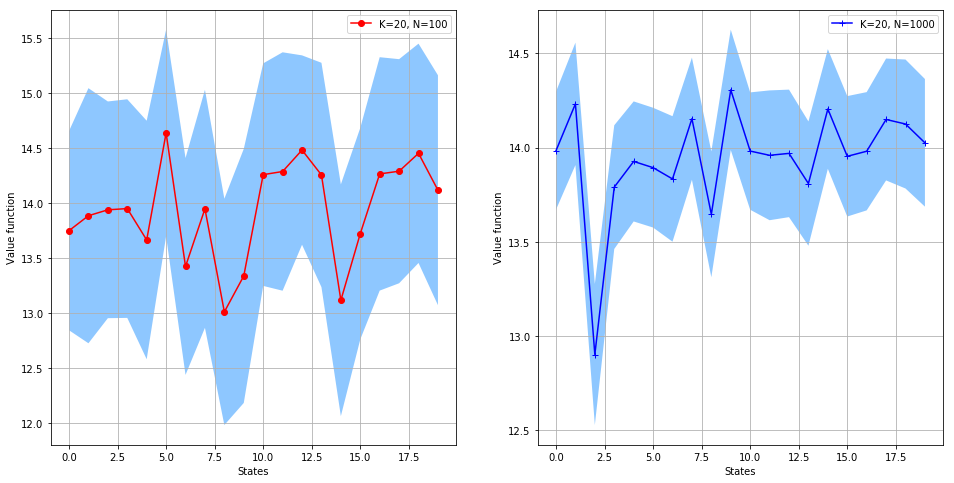

In [17]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(v1, color='r', marker='o', label='K=20, N=100')
plt.fill_between(x=np.arange(0,20,1), y1=Lower1, y2=Upper1, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.plot(v2, color='b', marker='+', label='K=20, N=1000')
plt.fill_between(x=np.arange(0,20,1), y1=Lower2, y2=Upper2, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

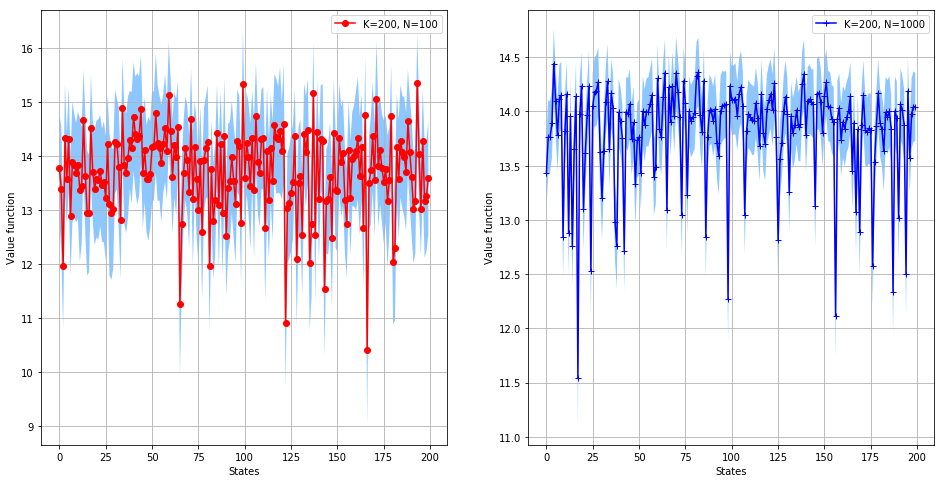

In [18]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(v3, color='r', marker='o', label='K=200, N=100')
plt.fill_between(x=np.arange(0,200,1), y1=Lower3, y2=Upper3, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.plot(v4, color='b', marker='+', label='K=200, N=1000')
plt.fill_between(x=np.arange(0,200,1), y1=Lower4, y2=Upper4, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

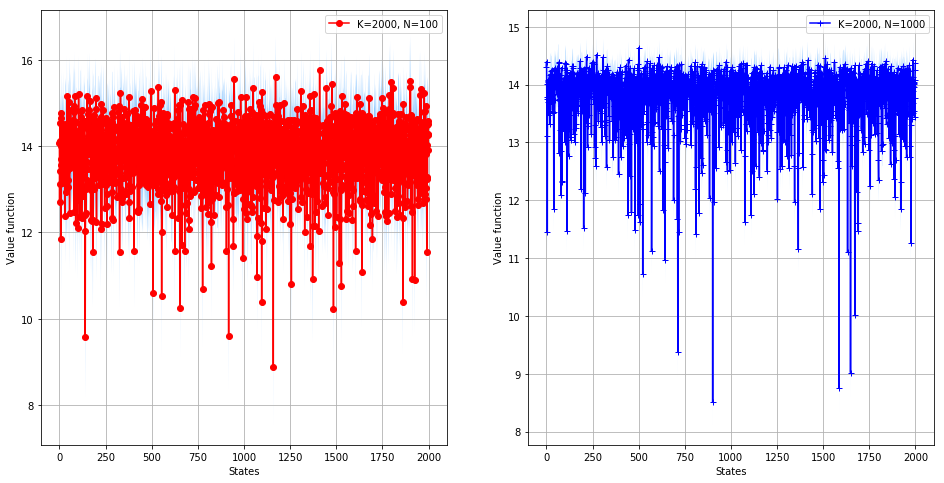

In [19]:
fig = plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(v5, color='r', marker='o', label='K=2000, N=100')
plt.fill_between(x=np.arange(0,2000,1), y1=Lower5, y2=Upper5, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.plot(v6, color='b', marker='+', label='K=2000, N=1000')
plt.fill_between(x=np.arange(0,2000,1), y1=Lower6, y2=Upper6, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

# Q2

In [20]:
import torch
import torch.utils.data as Data

## Neural Network

In [21]:
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Linear(in_features=6, out_features=32),
            torch.nn.ReLU()
        )
        self.out = torch.nn.Linear(in_features=32, out_features=1)
        
    def forward(self,x):
        x = self.layer1(x)
        return self.out(x)

In [22]:
train_X1 = torch.from_numpy(sample2)
train_Y1 = torch.from_numpy(v2)
train_X2 = torch.from_numpy(sample4)
train_Y2 = torch.from_numpy(v4)
train_X3 = torch.from_numpy(sample6)
train_Y3 = torch.from_numpy(v6)

## Generate test data 


Run the DTMC for 50000 period, sample ${X_{1000}, X_{2000} \cdots X_{50000}}$ as test dataset

In [23]:
test_Y, test_stds, test_X = value_func(50, 100)

100%|██████████| 50/50 [00:03<00:00, 14.21it/s]


In [24]:
test_CI = []

for j in range(test_Y.shape[0]):
    test_CI.append(ConfidenceInterval(test_Y[j], test_stds[j], 100))

In [25]:
LowerTest, UpperTest = seperate_bounds(test_CI)

In [26]:
test_X = torch.from_numpy(test_X)
test_Y = torch.from_numpy(test_Y)

### Train with K=20

In [27]:
train_set = Data.TensorDataset(train_X1, train_Y1)
train_loader = Data.DataLoader(dataset=train_set)

nn1 = NN()
optimizer = torch.optim.Adam(nn1.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

for epoch in range(100):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        output = nn1(batch_x.float())
        loss = criterion(output.float(), batch_y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch%10 == 0:
        test_output = nn1(test_X.float())
        test_loss = criterion(test_output.float(), test_Y.float())
        print('Epoch {}: mean square error = {}'.format(epoch, test_loss))

/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/site-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: mean square error = 7.755332946777344
Epoch 10: mean square error = 0.3273765444755554
Epoch 20: mean square error = 0.3178955316543579
Epoch 30: mean square error = 0.35591500997543335
Epoch 40: mean square error = 0.3951338231563568
Epoch 50: mean square error = 0.35288065671920776
Epoch 60: mean square error = 0.35058796405792236
Epoch 70: mean square error = 0.3949987590312958
Epoch 80: mean square error = 0.5528421998023987
Epoch 90: mean square error = 0.3316154479980469


In [28]:
Pred_1 = nn1(test_X.float())

### Train with K=200

In [29]:
train_set = Data.TensorDataset(train_X2, train_Y2)
train_loader = Data.DataLoader(dataset=train_set)

nn2 = NN()
optimizer = torch.optim.Adam(nn2.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

for epoch in range(100):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        output = nn2(batch_x.float())
        loss = criterion(output.float(), batch_y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch%10 == 0:
        test_output = nn2(test_X.float())
        test_loss = criterion(test_output.float(), test_Y.float())
        print('Epoch {}: mean square error = {}'.format(epoch, test_loss))

Epoch 0: mean square error = 0.37464439868927
Epoch 10: mean square error = 0.4998064935207367
Epoch 20: mean square error = 0.5524007081985474
Epoch 30: mean square error = 0.5057933926582336
Epoch 40: mean square error = 0.35356396436691284
Epoch 50: mean square error = 0.35105016827583313
Epoch 60: mean square error = 0.35536423325538635
Epoch 70: mean square error = 0.35844147205352783
Epoch 80: mean square error = 0.35724714398384094
Epoch 90: mean square error = 0.35891783237457275


In [30]:
Pred_2 = nn2(test_X.float())

### Train with K=2000

In [31]:
train_set = Data.TensorDataset(train_X3, train_Y3)
train_loader = Data.DataLoader(dataset=train_set)

nn3 = NN()
optimizer = torch.optim.Adam(nn3.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

for epoch in range(100):
    for step, (batch_x, batch_y) in enumerate(train_loader):
        output = nn3(batch_x.float())
        loss = criterion(output.float(), batch_y.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch%10 == 0:
        test_output = nn3(test_X.float())
        test_loss = criterion(test_output.float(), test_Y.float())
        print('Epoch {}: mean square error = {}'.format(epoch, test_loss))

Epoch 0: mean square error = 0.4073561429977417
Epoch 10: mean square error = 0.453418493270874
Epoch 20: mean square error = 0.47017520666122437
Epoch 30: mean square error = 0.508743166923523
Epoch 40: mean square error = 0.540961503982544
Epoch 50: mean square error = 0.49907588958740234
Epoch 60: mean square error = 0.5276789665222168
Epoch 70: mean square error = 0.5496132373809814
Epoch 80: mean square error = 0.546531081199646
Epoch 90: mean square error = 0.5454718470573425


In [32]:
Pred_3 = nn3(test_X.float())

## Question (a)
For question a, our result is:
$$\tilde v(x)=12.5928, 12.4252, 14.0874$$ for neural network trained with K=20, 200, 2000 respectively
$$\hat v(x)=11.2819,\ with\ confidence\ interval\ [10.9702, 11.5936]$$

In [33]:
xa = np.array([10,10,10,10,10,30]) ## here we use an alternative definition of x

In [34]:
MonteCarlo(xa, 1000)

(11.265413139833395, 4.878846195724499)

In [35]:
ConfidenceInterval(11.281940097692605, 5.0290641159780325, 1000)

[10.970235474424573, 11.593644720960636]

In [36]:
nn1(torch.from_numpy(xa).float())

tensor([13.8080], grad_fn=<AddBackward0>)

In [37]:
nn2(torch.from_numpy(xa).float())

tensor([12.7325], grad_fn=<AddBackward0>)

In [38]:
nn3(torch.from_numpy(xa).float())

tensor([13.5641], grad_fn=<AddBackward0>)

## Question (b)

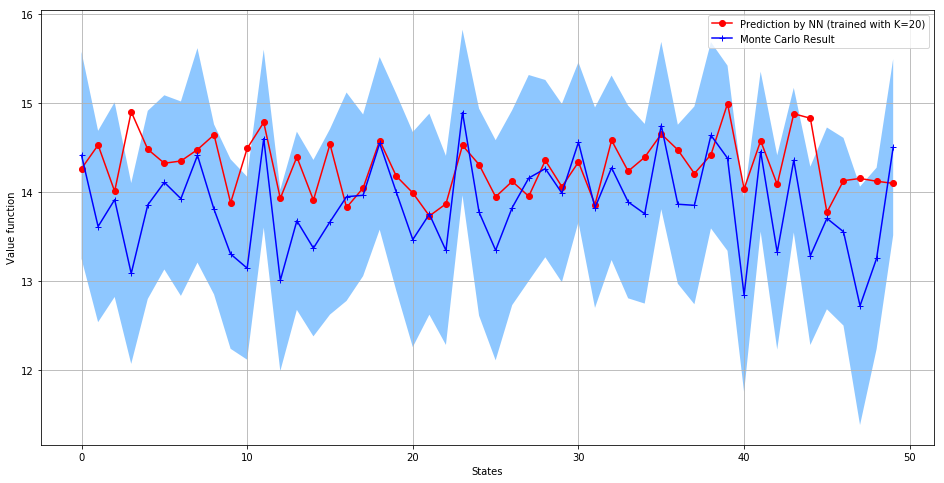

In [39]:
fig = plt.figure(figsize=(16,8))
plt.plot(Pred_1.data.numpy(), color='r', marker='o', label='Prediction by NN (trained with K=20)')
plt.plot(test_Y.data.numpy(), color='b', marker='+', label='Monte Carlo Result')
plt.fill_between(x=np.arange(0,50,1), y1=LowerTest, y2=UpperTest, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

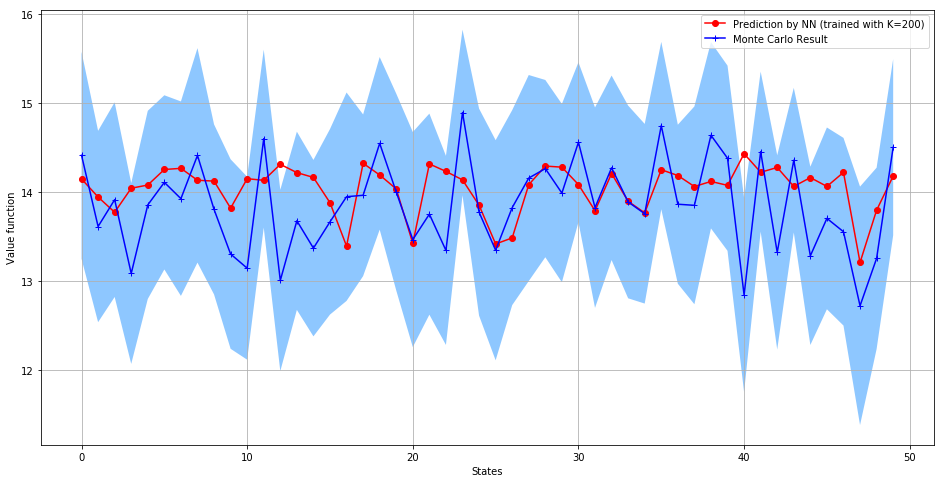

In [40]:
fig = plt.figure(figsize=(16,8))
plt.plot(Pred_2.data.numpy(), color='r', marker='o', label='Prediction by NN (trained with K=200)')
plt.plot(test_Y.data.numpy(), color='b', marker='+', label='Monte Carlo Result')
plt.fill_between(x=np.arange(0,50,1), y1=LowerTest, y2=UpperTest, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

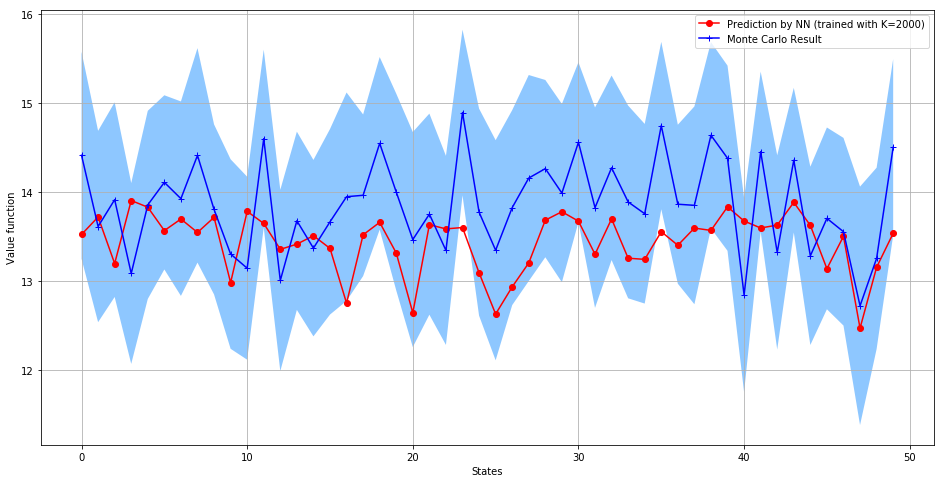

In [41]:
fig = plt.figure(figsize=(16,8))
plt.plot(Pred_3.data.numpy(), color='r', marker='o', label='Prediction by NN (trained with K=2000)')
plt.plot(test_Y.data.numpy(), color='b', marker='+', label='Monte Carlo Result')
plt.fill_between(x=np.arange(0,50,1), y1=LowerTest, y2=UpperTest, facecolor="dodgerblue", alpha=0.5)
plt.xlabel("States")
plt.ylabel("Value function")
plt.grid(True)
plt.legend(loc=1)

## Question (c)

In [42]:
test_output = nn1(test_X.float())
test_loss = criterion(test_output.float(), test_Y.float())
print("K=20: mean square error = {}".format(test_loss))

K=20: mean square error = 0.5433511137962341


In [43]:
test_output = nn2(test_X.float())
test_loss = criterion(test_output.float(), test_Y.float())
print("K=200: mean square error = {}".format(test_loss))

K=200: mean square error = 0.3671260178089142


In [44]:
test_output = nn3(test_X.float())
test_loss = criterion(test_output.float(), test_Y.float())
print("K=2000: mean square error = {}".format(test_loss))

K=2000: mean square error = 0.5454710125923157
